In [22]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
source_path = '/content/drive/MyDrive/Dataset/Dataset Iwak'

source_path_fresh = os.path.join(source_path, 'Fresh')
source_path_notfresh = os.path.join(source_path, 'Not Fresh')

# Delete non-images files
!find /content/drive/MyDrive/Dataset Iwak/ -type f ! -name "*.jpg" -exec rm {} +

print(f"There are {len(os.listdir(source_path_fresh))} images of fresh.")
print(f"There are {len(os.listdir(source_path_notfresh))} images of notfresh.")

find: ‘Iwak/’: No such file or directory
There are 3084 images of fresh.
There are 1306 images of notfresh.


In [25]:
root_dir = '/tmp/Fresh_notFresh'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
 
  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(root_path,'training/fresh'))
  os.makedirs(os.path.join(root_path,'training/notfresh'))
  os.makedirs(os.path.join(root_path,'validation'))
  os.makedirs(os.path.join(root_path,'validation/fresh'))
  os.makedirs(os.path.join(root_path,'validation/notfresh'))
  pass
  
  


  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [26]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/Fresh_notFresh/validation
/tmp/Fresh_notFresh/training
/tmp/Fresh_notFresh/validation/notfresh
/tmp/Fresh_notFresh/validation/fresh
/tmp/Fresh_notFresh/training/notfresh
/tmp/Fresh_notFresh/training/fresh


In [27]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  file_list = os.listdir(SOURCE_DIR)
  # Shuffle the file list
  random.shuffle(file_list)
  
  # Calculate the number of files for training
  training_number = int(len(file_list) * SPLIT_SIZE)
  i = 0
  target = TRAINING_DIR

  for item in file_list:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    
    if i == training_number:
      target = VALIDATION_DIR
  pass



In [28]:

FRESH_SOURCE_DIR = source_path_fresh
NOTFRESH_SOURCE_DIR = source_path_notfresh

TRAINING_DIR = "/tmp/Fresh_notFresh/training"
VALIDATION_DIR = "/tmp/Fresh_notFresh/validation"

TRAINING_FRESH_DIR = os.path.join(TRAINING_DIR, "fresh/")
VALIDATION_FRESH_DIR = os.path.join(VALIDATION_DIR, "fresh/")

TRAINING_NOTFRESH_DIR = os.path.join(TRAINING_DIR, "notfresh/")
VALIDATION_NOTFRESH_DIR = os.path.join(VALIDATION_DIR, "notfresh/")



# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_FRESH_DIR)) > 0:
  for file in os.scandir(TRAINING_FRESH_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_NOTFRESH_DIR)) > 0:
  for file in os.scandir(TRAINING_NOTFRESH_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_FRESH_DIR)) > 0:
  for file in os.scandir(VALIDATION_FRESH_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NOTFRESH_DIR)) > 0:
  for file in os.scandir(VALIDATION_NOTFRESH_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8


split_data(NOTFRESH_SOURCE_DIR, TRAINING_NOTFRESH_DIR, VALIDATION_NOTFRESH_DIR, split_size)
split_data(FRESH_SOURCE_DIR, TRAINING_FRESH_DIR, VALIDATION_FRESH_DIR, split_size)


print(f"\n\nOriginal fresh's directory has {len(os.listdir(FRESH_SOURCE_DIR))} images")
print(f"Original notfresh's directory has {len(os.listdir(NOTFRESH_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_NOTFRESH_DIR))} images of notfresh for training")
print(f"There are {len(os.listdir(TRAINING_FRESH_DIR))} images of fresh for training")
print(f"There are {len(os.listdir(VALIDATION_NOTFRESH_DIR))} images of notfresh for validation")
print(f"There are {len(os.listdir(VALIDATION_FRESH_DIR))} images of fresh for validation")



Original fresh's directory has 3084 images
Original notfresh's directory has 1306 images

There are 1044 images of notfresh for training
There are 2467 images of fresh for training
There are 262 images of notfresh for validation
There are 617 images of fresh for validation


In [29]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):


  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  # Instantiate the ImageDataGenerator class 
  validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [30]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 3511 images belonging to 2 classes.
Found 879 images belonging to 2 classes.


In [31]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-05 09:22:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  19.6MB/s    in 5.5s    

2023-06-05 09:22:55 (15.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [32]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [33]:
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.
  
  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    
  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = 'imagenet') 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False



  return pre_trained_model

In [34]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 74, 74, 32)  96          ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                      

In [35]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [36]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nReached 80.% accuracy so cancelling training!")
      self.model.stop_training = True

In [37]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model
  
  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from
    
  Returns:
    last_output: output of the model's last layer 
  """

  last_desired_layer = pre_trained_model.get_layer('mixed5')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [38]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed5/concat:0', description="created by layer 'mixed5'")


In [39]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [40]:
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  # x = layers.Flatten()(last_output)
  x = layers.GlobalAveragePooling2D()(last_output)
  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
 # x = layers.Dense(1024, activation='relu')(x)
  # x = layers.Dense(512, activation='relu')(x)
  x=layers.Dense(128,activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(32, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)     
  # Add a final sigmoid layer for classification
  x = layers.Dense (2, activation='softmax')(x)         

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = 'adam', 
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model

In [41]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 5,247,490 total parameters in this model.
There are 108,834 trainable parameters in this model.


In [42]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 75,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/75
176/176 - 46s - loss: 0.6050 - accuracy: 0.7007 - val_loss: 0.5763 - val_accuracy: 0.7019 - 46s/epoch - 262ms/step
Epoch 2/75
176/176 - 30s - loss: 0.5830 - accuracy: 0.7066 - val_loss: 0.5535 - val_accuracy: 0.7349 - 30s/epoch - 171ms/step
Epoch 3/75
176/176 - 29s - loss: 0.5695 - accuracy: 0.7086 - val_loss: 0.5259 - val_accuracy: 0.7372 - 29s/epoch - 167ms/step
Epoch 4/75
176/176 - 30s - loss: 0.5542 - accuracy: 0.7240 - val_loss: 0.5199 - val_accuracy: 0.7349 - 30s/epoch - 168ms/step
Epoch 5/75
176/176 - 30s - loss: 0.5415 - accuracy: 0.7343 - val_loss: 0.5149 - val_accuracy: 0.7349 - 30s/epoch - 173ms/step
Epoch 6/75
176/176 - 30s - loss: 0.5421 - accuracy: 0.7257 - val_loss: 0.5126 - val_accuracy: 0.7474 - 30s/epoch - 168ms/step
Epoch 7/75
176/176 - 30s - loss: 0.5383 - accuracy: 0.7263 - val_loss: 0.5124 - val_accuracy: 0.7486 - 30s/epoch - 168ms/step
Epoch 8/75
176/176 - 30s - loss: 0.5327 - accuracy: 0.7320 - val_loss: 0.4988 - val_accuracy: 0.7440 - 30s/epoch - 169

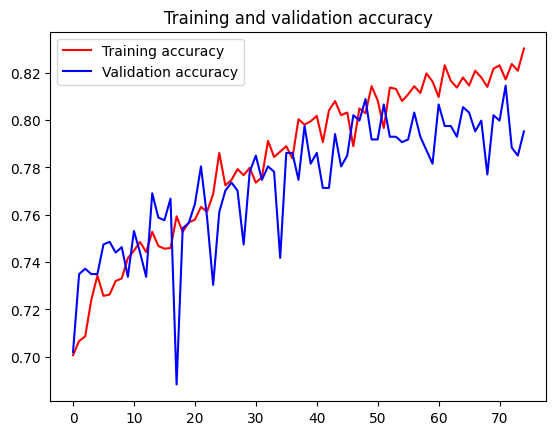

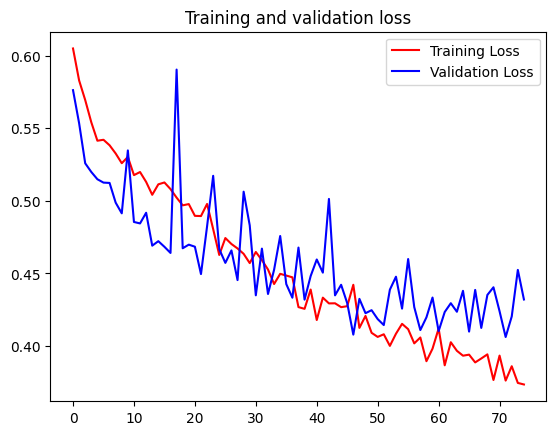

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# pre_trained_model.trainable = True

In [45]:
# print("Number of layers in the base model: ", len(pre_trained_model.layers))

In [46]:
# fine_tune_at = 250
# for layer in pre_trained_model.layers[:fine_tune_at]:
#  layer.trainable = False

In [47]:
# model = create_final_model(pre_trained_model, last_output)
# total_params = model.count_params()
# num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

# print(f"There are {total_params:,} total parameters in this model.")
# print(f"There are {num_trainable_params:,} trainable parameters in this model.")

In [48]:
# fine_tune_epoch = 25
# total_epochs = 75 + fine_tune_epoch

In [49]:
# callbacks = myCallback()
# history_fine = model.fit(train_generator,
#                     validation_data = validation_generator,
#                     epochs = total_epochs,
#                     initial_epoch = history.epoch[-1],
#                     verbose = 2,
#                     callbacks=callbacks)

In [50]:
# acc = history_fine.history['accuracy']
# val_acc = history_fine.history['val_accuracy']
# loss = history_fine.history['loss']
# val_loss = history_fine.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [51]:
# model.load_weights(latest)

In [60]:
model.save('/content/drive/MyDrive/Dataset Iwak/my_model_final_v2.h5')

In [53]:
# pip install tensorflowjs

In [54]:
# # bash

# tensorflowjs_converter --input_format keras \
#                        content/drive/MyDrive/Dataset Iwak/my_model.h5 \
#                        content/drive/MyDrive/Dataset Iwak/

In [61]:
import tensorflow as tf

In [62]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAUL

In [63]:
new_model= tf.keras.models.load_model(filepath="/content/drive/MyDrive/Dataset Iwak/my_model_final_v2.h5")


In [64]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model)

20972896

In [65]:
import pathlib
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Dataset Iwak/final_model_v1.tflite')
tflite_model_file.write_bytes(tflite_model)

20972896

In [67]:
new_model= tf.keras.models.load_model(filepath="/content/drive/MyDrive/Dataset Iwak/my_model_final_v2.h5")

In [72]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = new_model.predict(images, batch_size=5)
  
  print(classes)

Saving IMG_20190930_070337.jpg to IMG_20190930_070337 (1).jpg
Saving IMG_20190930_070621.jpg to IMG_20190930_070621.jpg
Saving IMG_20190930_070911.jpg to IMG_20190930_070911.jpg
1/1 [==============================] - 0s 22ms/step
[[0.9983601  0.00163994]]
1/1 [==============================] - 0s 22ms/step
[[0.9977894  0.00221065]]
1/1 [==============================] - 0s 21ms/step
[[0.9979729  0.00202706]]


In [ ]:
model.summary()